In [1]:
from fastai.vision.all import *
import cv2
import skimage as sm
import skimage.io
import tifffile
path = Path('/notebooks/EcadWatershedTrain')

In [2]:
# Training

valid_fnames = (path/'valid.txt').read_text().split('\n')
path_im = path/'dat/ecadBlur3_101/train_images'
path_lbl = path/'dat/ecadBlur3_101/train_masks'
codes = np.loadtxt(path/'codes.txt', dtype=str)
# codes = np.loadtxt(path/'codes.txt', dtype=str)
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)
get_msk = lambda o: path/f'dat/ecadBlur3_101/train_masks'/f'mask{o.stem.split("g")[1]}{o.suffix}'

camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(pad_mode='zeros'), Normalize.from_stats(*imagenet_stats)])

dls = camvid.dataloaders(path/f'dat/ecadBlur3_101/train_images', bs=4)
dls.vocab = codes
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean() 
opt = ranger
learn = unet_learner(dls, resnet101, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt).to_fp16()

# learn.load(f'ecadBlur3Watershed_101')


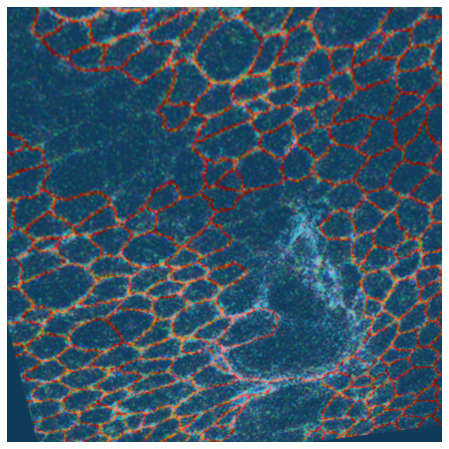

In [3]:
dls.show_batch(max_n=1, figsize=(8,8))

SuggestedLRs(valley=tensor(9.1201e-05))

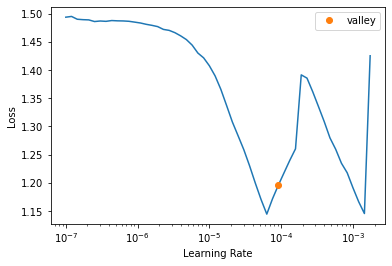

In [4]:
learn.lr_find()

In [4]:
learn.fine_tune(10, base_lr=1e-4)
learn.save(f'ecadBlur3Watershed_101')

epoch,train_loss,valid_loss,acc_camvid,time
0,0.663803,0.559899,0.847421,06:08


epoch,train_loss,valid_loss,acc_camvid,time
0,0.305104,0.269454,0.881050,04:46
1,0.271666,0.221161,0.901284,04:46
2,0.243095,0.203378,0.912451,04:46
3,0.222027,0.174956,0.925138,04:46
4,0.204387,0.171006,0.927195,04:46
5,0.193837,0.158958,0.932416,04:46
6,0.186533,0.158474,0.932840,04:46
7,0.179874,0.154965,0.934143,04:46
8,0.177157,0.153447,0.934887,04:46
9,0.174866,0.153200,0.935028,04:46


Path('models/ecadBlur3Watershed_101.pth')

SuggestedLRs(valley=tensor(2.7542e-06))

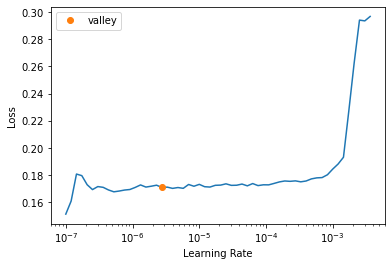

In [5]:
learn.unfreeze()
learn.lr_find()

In [7]:
learn.fine_tune(2, base_lr=1e-5)
learn.save(f'ecadBlur3Watershed_101')
learn.fine_tune(2, base_lr=5e-6)
learn.save(f'ecadBlur3Watershed_101')

epoch,train_loss,valid_loss,acc_camvid,time
0,0.169444,0.150111,0.936199,04:42


epoch,train_loss,valid_loss,acc_camvid,time
0,0.170437,0.150246,0.936152,04:46
1,0.169443,0.150196,0.936262,04:47


epoch,train_loss,valid_loss,acc_camvid,time
0,0.169358,0.149742,0.936230,04:43


epoch,train_loss,valid_loss,acc_camvid,time
0,0.171737,0.150309,0.936224,04:46
1,0.169230,0.149947,0.936249,04:47


Path('models/ecadBlur3Watershed_101.pth')

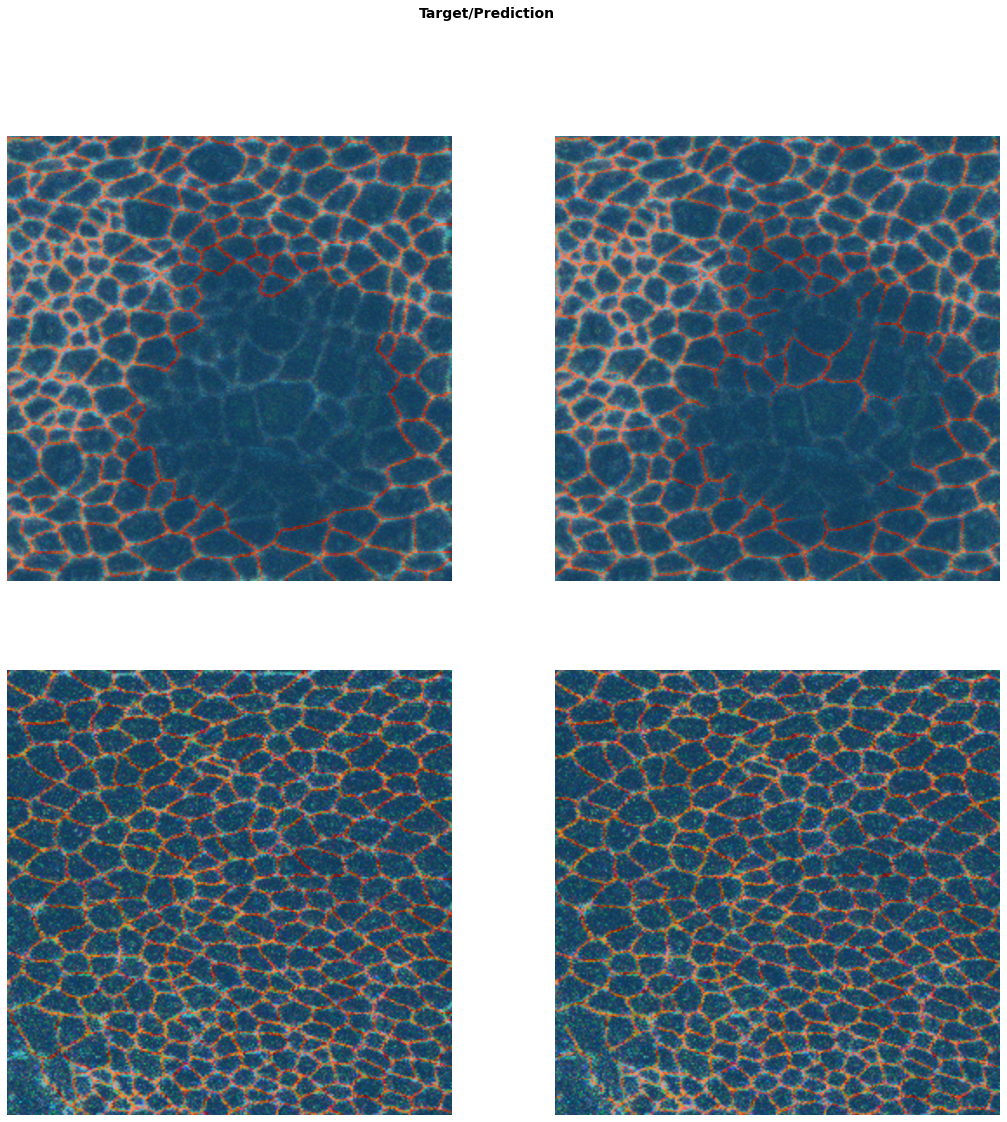

In [8]:
learn.show_results(max_n=2, figsize=(18,18))

In [9]:
model = learn.model
i = 0
for name, module in model.named_modules():
#     print(name)
    i+=1
print(i)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

378
361011541


In [ ]:
learn.save(f'UNetBoundary')